<a href="https://colab.research.google.com/github/alfinmaulani/skripsi2/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.7 MB/s eta 0:00:00


In [1]:
import torch

if torch.cuda.is_available():
  # device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))

else:
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

No GPU available, using the CPU instead


In [6]:
korpusgabung='/content/drive/MyDrive/fake news/beritapalsugabung.csv'
df=pd.read_csv(korpusgabung)
# df.columns=['teks']

In [7]:
df

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0
...,...,...
44893,BRUSSELS (Reuters) - NATO allies on Tuesday we...,1
44894,"LONDON (Reuters) - LexisNexis, a provider of l...",1
44895,MINSK (Reuters) - In the shadow of disused Sov...,1
44896,MOSCOW (Reuters) - Vatican Secretary of State ...,1


In [9]:
df.shape

(44898, 2)

In [17]:
df.label.value_counts().index

Int64Index([0, 1], dtype='int64')

In [20]:
df.label.value_counts()

0    23481
1    21417
Name: label, dtype: int64

Text(0, 0.5, 'samples')

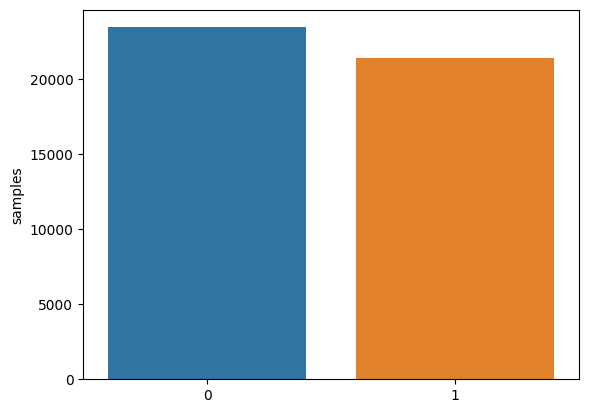

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

x=df.label.value_counts()
sns.barplot(x=x.index, y=x)
plt.gca().set_ylabel('samples')